---
title: 1D Linear Convection
suptitle: Time Steppers with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

> In the previous tutorial, we broke up all of the pieces into abstract concepts. We also looked at how to jax-ify all the things by creating functions for all of the bits and pieces; ranging from the domain definition to the stepper. In this tutorial, we will repeat the same procedure but define some `pytree` objects which we will operator. Many times, we need more than just the array values. There is a lot of auxillary information including stuff about the domain.


In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recall: PDE - 1D Linear Convection

Let's continue from the previous tutorial. Recall, we are working with a 1D Linear Convection scheme:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$ (pde)

For the PDE {eq}`pde`, we are going to do a backwards difference discretization in space and a forwards in time.

### Spatial Domain

We define our spatial discretization as:

$$
x \in \Omega \sub \mathbb{R}^{D}
$$ (spatial_d)

Where:

* $\mathbb{R}^D$ - the space of coordinates, e.g. Euclidean, Spherical, and the size, e.g. scalar, vector, etc
* $\Omega$ - the domain and discretization

For this problem our domain bounds are $[0.0, 2.0]$ and our time step is $\Delta x\sim 0.04$.


In [2]:
from jaxsw._src.domain.base import Domain

There are a few ways to initialize the domain. Here are a few:

* Define the number of values and the step
* Define the start/end points and the number of values


In [3]:
xmin = 0.0
xmax = 2.0
nx = 50


domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,))
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")
print(f"dx: {domain.dx}")

Size: (50,)
nDims: 1
Grid Size: (50, 1)
Cell Volume: 0.04081632653061224
dx: (0.04081632653061224,)


### Initial Condition

We said that the initial condition is actually a function which operates on a discretized domain $\Omega$.


$$
\mathcal{IC}[u](x,0) = 
\begin{cases}
2 & \text{where } 0.5 \leq x \leq 1,\\
1 & \text{everywhere else in } (0,2) \\
\end{cases}
$$ (ic)

In practical terms, we need to initialize our state, $u$, based on the domain and discretization, $\Omega$.

$$
\mathcal{IC}[u](x,0):= \boldsymbol{IC}(\Omega, x)
$$ (ic_practical)

In [4]:
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.fields.base import Field

In [5]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.ones_like(domain.grid, dtype=jnp.float64)

    u = u.at[int(0.5 / domain.dx[0]) : int(1 / domain.dx[0] + 1)].set(2.0)
    return u

In [6]:
u_init = init_u0(domain)

### Boundary Conditions

For the boundary conditions, this is another function that is dependent upon the domain and discretization. It can be defined as:

$$
\mathcal{BC}[u](x, t) = 1.0, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)


In practical terms, we want to apply some function, $\boldsymbol{b}$, which modifies our state, $u$, at the coordinates along the boundaries of the domain, i.e. $x \in \partial\Omega$. In our case it is constant. But we can easily think of strategies where it is an actual function.

In [7]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    u = u.at[0].set(1.0)

    u = u.at[-1].set(1.0)

    return u

In [8]:
u_out = bc_fn(u_init)

### Differential Operators

We identified the differential operators, $\mathcal{N}[\cdot;\boldsymbol{\theta}]$ on the RHS of the equation. In this case, we used the backwards time finite difference method because this is a convection scheme. There are (hyper)-parameters, $\boldsymbol{\theta}$, in every differential operator because there are possibly (ad-hoc) decisions that one must make for all discretizations, e.g. finite difference schem (backwards, forwards, central) and stencil order. 

The 1st order backwards difference is defined as:

$$
\mathcal{N}[u](x) := D^-(x)=\frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (bd)

We showcased how we can use the stencil operator as a way to handle finite differences instead of the messy slicing operations. (Tutorial on this soon!)

In [9]:
du_dx = fdx.difference(
    u_init, axis=0, step_size=domain.dx[0], method="backward", accuracy=1
)

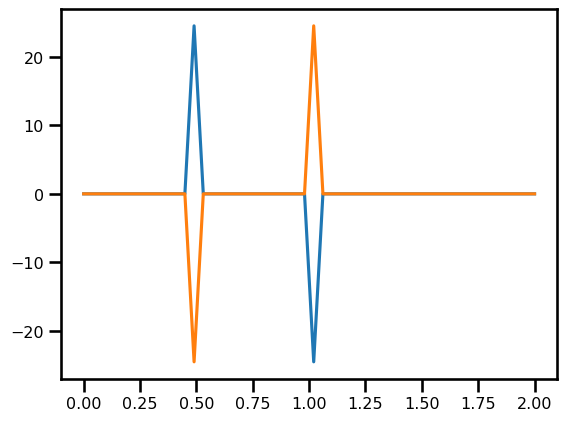

In [10]:
fig, ax = plt.subplots()

ax.plot(domain.coords[0], du_dx[..., 0])
ax.plot(domain.coords[0], -du_dx[..., 0])
plt.show()

### Right Hand Side

Now, this is the ultimate part that glues the differential operators and the boundary conditions together.

$$
\begin{aligned}
\mathcal{F}[u] &= - c \cdot \mathcal{N}_\text{BackDiff}[u;\boldsymbol{\theta}](x) \hspace{10mm} x\in\Omega
\end{aligned}
$$ (rhs_complete)

We dump all of this within the function to define our RHS function.

In [11]:
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import advection

In [20]:
c = 1.0


class LinearAdvection1D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, u: Array, args) -> Array:
        u = bc_fn(u)

        c = args

        rhs = -advection.advection_1D(
            u, a=c, step_size=domain.dx[0], axis=0, accuracy=1
        )
        return rhs

In [21]:
out = LinearAdvection1D.equation_of_motion(0, u_init, c)

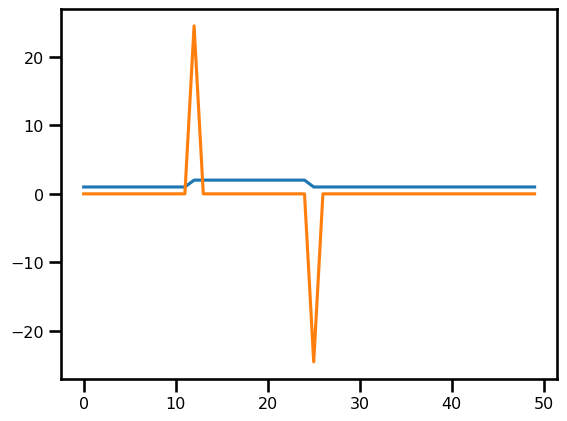

In [22]:
fig, ax = plt.subplots()

ax.plot(u_init)
ax.plot(-out[..., 0])
plt.show()

## Time Stepping

So in the previous tutorial, we talked about the step function but let's pause for a moment and rethink. The step function is actually a combination of two things:

1. The RHS which includes the spatial derivatives.
2. The time stepping scheme

We have already taken care of the spatial derivatives in the previous step. So looking again at equations {eq}`pde` and {eq}`discretization_full`, we write the half step in between them.

$$
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (pde_spatial_discretization)

where we have the RHS as defined in equation {eq}`rhs_complete` but we *did not* write the time stepping scheme for Euler. Instead, we're going to offset this to another library called `diffrax`.

### Temporal Domain

We define our temporal discretization as:

$$
t \in \mathcal{T} \sub \mathbb{R}^+
$$ (time_d)

where the space time coordinates are bounded by $\mathcal{T}=[0,T]$. For our problem, it is bounded between $[0.0, 0.5]$. Recall, the time step was calculated from the CFL condition given by

$$
\Delta t = \frac{\sigma\Delta x}{c} \leq 1
$$ (cfl_advection_dt)



In [23]:
# SPATIAL DISCRETIZATION
u_init = init_u0(domain)

# TEMPORAL DISCRETIZATION
# initialize temporal domain
t0 = 0.0
tmax = 0.5


# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c


# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=domain.dx[0], c=c, sigma=sigma)

t_domain = TimeDomain(tmin=0.0, tmax=0.5, dt=dt)
ts = jnp.linspace(t0, tmax, 25)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearAdvection1D(
    t_domain=t_domain,
    saveat=saveat,
)


# integration
u_sol = dyn_model.integrate(u_init, dt, c)

In [24]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()


sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=u_init.squeeze(),
    saveat=saveat,
    args=c,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [25]:
da_sol = xr.DataArray(
    data=np.asarray(sol.ys),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)
da_sol

<xarray.DataArray (time: 25, x: 50)>
array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.00026568, 1.0000889 ,
        1.00003886],
       [1.        , 1.        , 1.        , ..., 1.00056907, 1.00020463,
        1.00009947],
       [1.        , 1.        , 1.        , ..., 1.00113427, 1.0004358 ,
        1.00023425]])
Coordinates:
  * x        (x) float64 0.0 0.04082 0.08163 0.1224 ... 1.878 1.918 1.959 2.0
  * time     (time) float64 0.0 0.02083 0.04167 0.0625 ... 0.4583 0.4792 0.5
Attributes:
    pde:      linear_convection
    c:        1.0
    sigma:    0.2

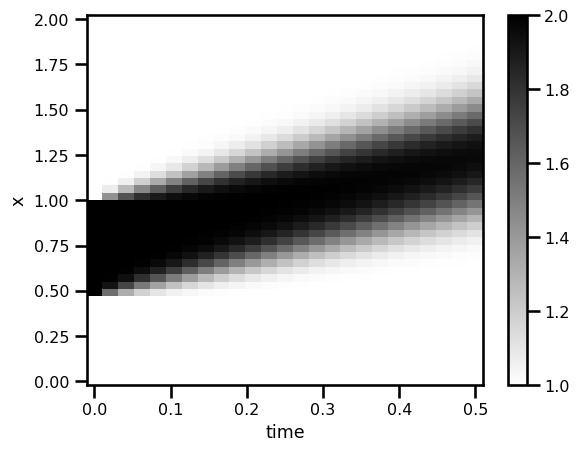

In [26]:
fig, ax = plt.subplots()

da_sol.T.plot.pcolormesh(ax=ax, cmap="gray_r")

plt.show()

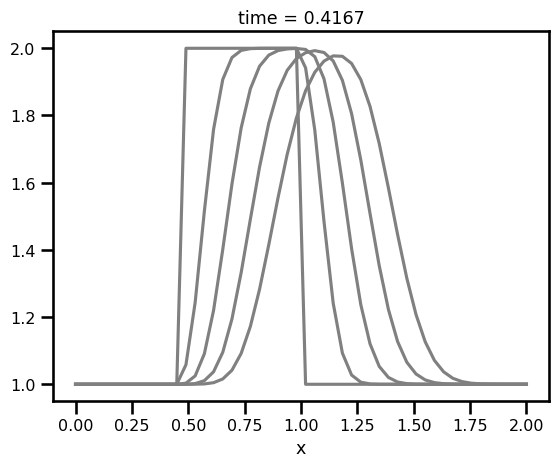

In [27]:
fig, ax = plt.subplots()

for i in range(0, len(da_sol.time), 5):
    da_sol.isel(time=i).plot.line(ax=ax, color="gray")

plt.show()

As we can see, there seems to be some dissipation. Could be the solver? Something to think about. But I think the most important thing is the fact that it is so easy to just try things without getting bogged down by the coding details!!

At least that is what I hope to convey!